# Natural Language Processing (NLP) with Natural Language Toolkit (NLTK) and Machine Learning Algorithms

In this notebook, we will be using [NLTK](https://www.nltk.org/) and [ScikitLearn](https://scikit-learn.org/) to handle some of the very basic tasks in NLP world.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

%matplotlib inline

## Downloading NLTK `Stopwords` Corpus

We will use `NLTK`'s `download_shell` method to download a copus called `stopwords`. This corpus contains lists of stop words for several languages. These are high-frequency grammatical words which are usually ignored in text retrieval applications.

In [2]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  stopwords


        C:\Users\hoang.tran\AppData\Roaming\nltk_data...
      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


## Loading the Data

This notebook uses a data set [`SMSSpamCollection.tsv`](./smsspamcollection/SMSSpamCollection.tsv) which can be downloaded from the [UC Irvine Machine Learning Repository](https://archive-beta.ics.uci.edu/). The [SMS Spam Collection](https://archive-beta.ics.uci.edu/ml/datasets/sms+spam+collection) is a public set of SMS labeled messages that have been collected for mobile phone spam research.

### Quick Look at the Data

In [3]:
# Use rstrip() and list comprehension to get a list of all lines
# of the data set input file. rstrip() will remove the right-hand-side newline character '\n'
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection.tsv', encoding='utf-8')]
len(messages)

5574

In [4]:
messages[:5]

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'ham\tU dun say so early hor... U c already then say...',
 "ham\tNah I don't think he goes to usf, he lives around here though"]

<font color=magenta>A collection of texts is also sometimes called `corpus`. Let's print out the `10th` to `19th` (`10`)  messages and number them using `enumerate`.</font>

In [5]:
for message_no, message in enumerate(messages[10:20], 10):
    print(message_no, '>> ', message, '\n')

10 >>  ham	I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today. 

11 >>  spam	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info 

12 >>  spam	URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18 

13 >>  ham	I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times. 

14 >>  ham	I HAVE A DATE ON SUNDAY WITH WILL!! 

15 >>  spam	XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL 

16 >>  ham	Oh k...i'm watching here:) 

17 >>  ham	Eh u remember how 2 spell his name... Yes i did. He v naughty make until i v wet. 

<font color=magenta>Looking at the above printing result, we can tell that this is a [TSV](https://en.wikipedia.org/wiki/Tab-separated_values) file, where the first column is a label saying whether the given message is a normal message (commonly known as `ham`) or `spam`. The second column is the message itself.(Note our left-hand-side numbers and `>>` aren't part of the file, they are just to number each row of the data to be printed).</font>

<font color=green>Using these labeled `ham` and `spam` examples, we'll **train a machine learning model to learn to discriminate between `ham`/`spam` automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as `ham` or `spam`.</font>

<font color=green>From the official [ScikitLearn documentation](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/tutorial/plot_ML_flow_chart.html), we can visualize our process as follows
![Text Processing Model Process](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/_images/plot_ML_flow_chart_2.png)</font>

### Loading the Data Using Pandas

Manually pasing `TSV` with Python is fine. `Pandas`, however, provides a method to read in `TSV` more conveniently. So let's use `Pandas` to load in the data.

In [6]:
# Read in the SMS messages data and name the data columns
messages = pd.read_csv(
    'smsspamcollection/SMSSpamCollection.tsv',
    sep='\t',
    names=['label', 'message']
)
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Exploratory Data Analysis

In [7]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
# Use `groupby` to use `describe` by `label`, this way we can begin
# to think about the features that separate `ham` and `spam`
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

<font color=magenta>**Feature Engineering**<br>
As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general.
<br><br>
Let's make a new column to detect how long the text messages are:</font>

In [9]:
messages['length'] = messages['message'].apply(len)
messages

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


### Data Visualization

<AxesSubplot:xlabel='length', ylabel='Count'>

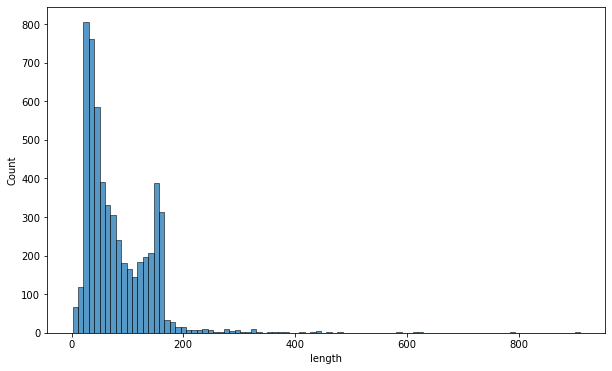

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=messages, x='length')

<AxesSubplot:xlabel='length', ylabel='Count'>

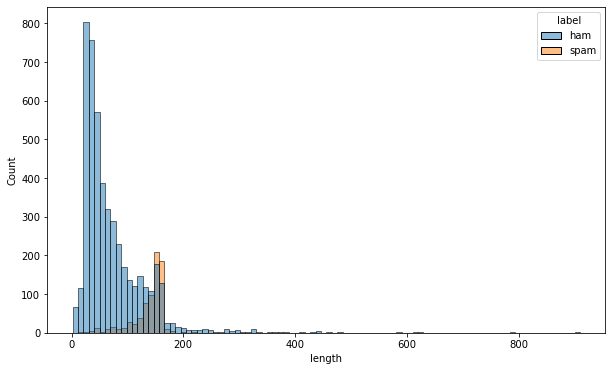

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=messages, x='length', hue='label')

<font color=magenta>Looks like text length may be a good feature to think about! Let's try to explain why the `x-axis` (`length`) goes all the way to more than `800`, this must mean that there is some really long message!</font>

In [12]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

The longest message has `910` characters. Let's use masking to find this message.

In [13]:
messages[messages['length'] == 910]

,label,message,length
1085,ham,For me the love should start with attraction.i...,910


In [14]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

<font color=magenta>Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam.</font>

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

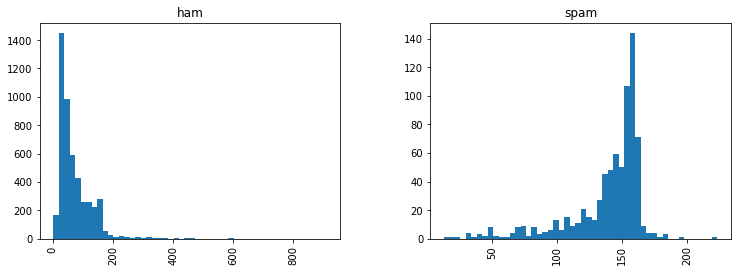

In [15]:
messages.hist(column='length', by='label', bins=50, figsize=(12,4))

<font color=magenta>Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters. (Sorry Romeo!)</font>

## Text Pre-Processing

<font color=magenta>Our main issue with our data is that it is all in text format (strings). The classification algorithms that `ScikitLearn` provides will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.
<br><br>
In this section we'll convert the raw messages (sequence of words) into vectors (sequences of numbers).
<br><br>
As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.
</font>

### Removing Punctuation

<font color=green>First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:</font>

In [16]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Get only characters that are not in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string
nopunc = ''.join(nopunc)

nopunc

'Sample message Notice it has punctuation'

### Removing Stopwords

<font color=green>Now let's see how to remove `stopwords`. We can import a list of English `stopwords` from `NLTK`.</font>

In [17]:
from nltk.corpus import stopwords

In [18]:
# Get a list of English stopwords
stws = stopwords.words('english')
print(len(stws))
stws[0:10]

179


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [19]:
# Split the string without punctuations into single words
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [20]:
# Remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

### Defining a Utility Function to Remove Both Punctuation and Stopwords

<font color=green>Now let's put both of these together in a function to apply it to our DataFrame later on.</font>

In [21]:
def text_process(mess: str):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Get only characters that are not in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string
    nopunc = ''.join(nopunc)
    
    # Remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [22]:
# Check the original messages DataFrame
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<font color=green>Now, let's `tokenize` these messages. Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens (words).
<br><br>
Let's see an example output on one column.
<br><br>
**Note:** We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol).</font>

In [23]:
# Check to make sure our text_process() function works
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Continuing Normalization

<font color=green>There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).<br><br>
`NLTK` has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand. For example,
<br>
> `Nah dawg, IDK! Wut time u headin to da club?`
    
versus

>`No dog, I don't know! What time are you heading to the club?`

Some text normalization methods will have trouble with this type of shorthand. See [NLTK book online](http://www.nltk.org/book/) for more advanced methods.

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.</font>

## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

| | Message 1 | Message 2 | ... | Message N |
|-|-----------|-----------|-----|-----------|
| Word 1 Count | 0 | 1 | ... | 0 |
| Word 2 Count | 0 | 1 | ... | 0 |
| ... | 1 | 2 | ... | 0 |
| Word n Count | 0 | 1 | ... | 1 |

Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [25]:
# Might take awhile
bow_transformer = CountVectorizer(
    analyzer=text_process
).fit(messages['message'])

# Print total number of vocab words
len(bow_transformer.vocabulary_)

11425

In [26]:
# Now let's vectorize a message
message4 = messages['message'][3]
print(message4)

bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

U dun say so early hor... U c already then say...
  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [27]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [28]:
messages_bow = bow_transformer.transform(messages['message'])

In [29]:
print(f'Shape of Sparse Matrix: {messages_bow.shape}')
print(f'Amount of Non-Zero occurences: {messages_bow.nnz}')

Shape of Sparse Matrix: (5572, 11425)
Amount of Non-Zero occurences: 50548


In [30]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print(f'sparsity: {round(sparsity)}')

sparsity: 0


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

___
### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
___

Let's go ahead and see how we can do this in SciKit Learn:

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

<font color=magenta>Create a `TF-IDF` transformer and call its `fit` method to learn the idf vector (global term weights).</font>

In [32]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [33]:
# Check tf-idf for a specific message (the 4th message)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [34]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


<font color=magenta>Now, let's transform the entire `bag-of-words` corpus into `TF-IDF` corpus at once.</font>

In [35]:
# Transform a count matrix to a tf or tf-idf representation
messages_tfidf = tfidf_transformer.transform(messages_bow)
messages_tfidf.shape

(5572, 11425)

> There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". Check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

## Training a Model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [36]:
from sklearn.naive_bayes import MultinomialNB

In [37]:
# Create a spam detection model and fit it to the tf-idf and message
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [38]:
# Let's try classifying our single random message and checking how we do
print(f'predicted: {spam_detect_model.predict(tfidf4)[0]}')
print(f'expected: {messages.label[3]}')

predicted: ham
expected: ham


Fantastic! We've developed a model that can attempt to predict spam vs ham classification!

## Model Evaluation

Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [39]:
all_predictions = spam_detect_model.predict(messages_tfidf)
all_predictions

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

Let's create a classification report using SciKit Learn's built-in classification report, which returns [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification).

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

In [40]:
from sklearn.metrics import classification_report, plot_confusion_matrix

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



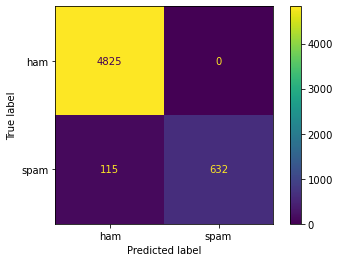

In [41]:
print(classification_report(messages['label'], all_predictions))
plot_confusion_matrix(spam_detect_model, messages_tfidf, messages['label'])

There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" is probably much lower than mis-predicting "ham" as "spam".

<font color=red>In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**
<br><br>
Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.
<br><br>
A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.</font>

## Train Test Split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
msg_train, msg_test, label_train, label_test = train_test_split(
    messages['message'],
    messages['label'],
    test_size=0.2,
    random_state=45
)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572).

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [44]:
from sklearn.pipeline import Pipeline

In [45]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)), # strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()), # train on TF-IDF vectors w/ Naive Bayes classifier
])

<font color=magenta>Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:</font>

In [46]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001719BF56670>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [47]:
predictions = pipeline.predict(msg_test)

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       966
        spam       1.00      0.62      0.76       149

    accuracy                           0.95      1115
   macro avg       0.97      0.81      0.87      1115
weighted avg       0.95      0.95      0.94      1115



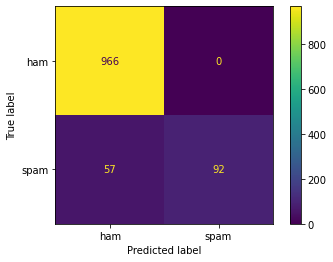

In [48]:
print(classification_report(label_test, predictions))
plot_confusion_matrix(pipeline, msg_test, label_test)

## More Resources

Check out the links below for more info on Natural Language Processing:

[NLTK Book Online](http://www.nltk.org/book/)

[Kaggle Walkthrough](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)